## we are using mobilenet_v2 model. It is very light weight. Here we have used transfer learning , where we cut the last layer and use our own layer in its place.

In [1]:
import numpy as np
import os # to access dataset
import matplotlib.pyplot as plt# to create graphs
from imutils import paths # to access datsset

#importing CNN structures
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam# the gradient descent function
#we need to preprocees data before using mobilenet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


from tensorflow.keras.preprocessing.image import ImageDataGenerator#to augment data
from tensorflow.keras.preprocessing.image import img_to_array# to covert images to array
from tensorflow.keras.preprocessing.image import  load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer# to conert labels into form which our model can undrstand
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Dataset

In [2]:
dataset=r'F:\Data_Science_ML\Mask_detection_project\Dataset'
imagePaths=list(paths.list_images(dataset))

In [ ]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))#converting image to std size
    image=img_to_array(image)
    image=preprocess_input(image)#scaling pixcel intensities to [-1,1]
    data.append(image)


In [3]:
#converting lists to numpy array
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [4]:
image=load_img(i,target_size=(224,224))#converting image to std size
image=img_to_array(image)
image=preprocess_input(image)

In [20]:
image.shape

(224, 224, 3)

In [6]:
#perform hot code encoding
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [8]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
#splitting data into train and test data
# 80% data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.20,random_state=10,stratify=labels)

In [10]:
X_train.shape

(1100, 224, 224, 3)

In [11]:
X_test.shape

(276, 224, 224, 3)

In [12]:
#augment data
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                       height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,
                       vertical_flip=True,fill_mode='nearest')

# Designing our model

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)#flatten the input layer into single vector
headModel=Dense(128,activation='relu')(headModel)# adding a fully connected layer of 128 neurons 
headModel=Dropout(0.5)(headModel)# it prevents model from overfitting
headModel=Dense(2,activation='softmax')(headModel)

#placing head model on base model
model=Model(inputs=baseModel.input,outputs=headModel)

In [2]:
#model.summary()

In [15]:
#we are not going to train base model
for layer in baseModel.layers:
    layer.trainable=False

In [3]:
#model.summary()

In [16]:
#compile model
learning_rate=0.001
Epochs=20 # no. of times models goes through images
BS=12 #batch size
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
#train the head
H=model.fit(
    aug.flow(X_train,y_train,batch_size=BS),
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    epochs=Epochs)
#serialize model on disk
model.save(r'F:\Data_Science_ML\Mask_detection_project\mobilenet_v2.model')

Epoch 1/20
91/91 [==============================] - 19s 212ms/step - loss: 0.1846 - accuracy: 0.9228 - val_loss: 0.0529 - val_accuracy: 0.9855
Epoch 2/20
91/91 [==============================] - 20s 218ms/step - loss: 0.0577 - accuracy: 0.9779 - val_loss: 0.0349 - val_accuracy: 0.9855
Epoch 3/20
91/91 [==============================] - 20s 224ms/step - loss: 0.0442 - accuracy: 0.9853 - val_loss: 0.0357 - val_accuracy: 0.9819
Epoch 4/20
91/91 [==============================] - 21s 226ms/step - loss: 0.0546 - accuracy: 0.9807 - val_loss: 0.0408 - val_accuracy: 0.9819
Epoch 5/20
91/91 [==============================] - 21s 226ms/step - loss: 0.0432 - accuracy: 0.9798 - val_loss: 0.0451 - val_accuracy: 0.9819
Epoch 6/20
91/91 [==============================] - 21s 227ms/step - loss: 0.0338 - accuracy: 0.9853 - val_loss: 0.0306 - val_accuracy: 0.9891
Epoch 7/20
91/91 [==============================] - 21s 229ms/step - loss: 0.0409 - accuracy: 0.9835 - val_loss: 0.0335 - val_accuracy: 0.9891

In [17]:
predict=model.predict(X_test,batch_size=BS)
predict=np.argmax(predict,axis=1)
true_val=np.argmax(y_test,axis=1)


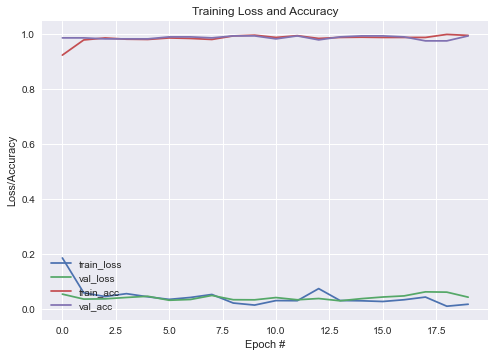

In [27]:
# plot the training loss and accuracy
N = Epochs
plt.style.use("seaborn")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(r"F:\Data_Science_ML\Mask_detection_project\plot.png")

In [21]:
true_val.shape

(276,)

In [22]:
predict.shape

(276,)

In [23]:
print(classification_report(true_val,predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [42]:
#model.save(r'F:\Data_Science_ML\Mask_detection_project\mobilenet_v2.model.')

INFO:tensorflow:Assets written to: F:\Data_Science_ML\Mask_detection_project\mobilenet_v2.model.\assets
